#### Code for the Poster Contribution A 133 "Go- no-go decisions based on gradually revealed visual information" at V-VSS 2021
##### by Clara Kuper
##### April 2021

In this code, I will review and discuss the data from a pilot experiment. Substantial parts of this analysis are 
presented at V-VSS 2021 in poster session A, on Saturday, the 22nd of May 2021. This notebook includes more analysis and 
information than included in the poster. Figures used in the poster are marked as 
"V-VSS 2021 Figure" and the corresponding analysis is marked as "V-VSS 2021 Analysis"

In this notebook, I will follow these steps:

0. Load the needed libraries and data files

1. review the data 
    
    a. describe size, structure
    
    b. show basic behavioural measurements (V-VSS 2021 Figures & Code)
    
    
2. describe different strategies to solve the task
    
    a. explain how hit probability was computed
    
    b. compare ideal observers using different strategies
    
    c. fit linear models to models the response type (go/ no-go). (V-VSS 2021 Figures & Code)
    
    d. fit linear models to the reaction time (V-VSS 2021 Figures & Code)
    
    
3. describe the time windows that had an influence on the response (V-VSS 2021 Figures & Code)
    
    a. modeled forwards, from the start of each trial
    
    b. modeled backwards, from the response in each trial
    
    
5. describe 3 mechanisms, based on drift diffusion models, and compare their simulated output to 3. (V-VSS 2021 Figures & Code)

In [16]:
##################################
# import the necessary libraries #
##################################
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import utils.utils as utils# custom functions
import utils.plotting as plotting # custom plotting
import math
import pickle
import os
import scipy.stats as stats

############ 
# import R #
############
# we will use the R framework to fit mixed effect models
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'
# pymer is built on the lme4 package in R
from pymer4.models import Lmer, Lm

############################
# import the pyDDM library #
############################
from ddm import Fittable, Model, Sample, Bound
from ddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, Drift
from ddm.functions import fit_adjust_model, display_model
import ddm.plot

##############
# data paths #
##############
path_data = './data/'
path_figs = './figures/'
path_models = './models/'

############## 
# data files #
##############
# wide df
df_short = pd.read_csv(path_data+'dataframe_short.csv', sep = ',')
# long df
df_long = pd.read_csv(path_data+'dataframe_long.csv', sep = ',')

## when fitting reaction times, we will need only the trial with "go" responses
responses = [0,1]
df_go, df_nogo = utils.split_df(df_short, 'goResp', responses)

# print some information about the data frames:
print(f"The long df has {df_long.shape[1]} columns and {df_long.shape[0]} rows")
print(f"The short df has {df_short.shape[1]} columns and {df_short.shape[0]} rows")
print(f"The go df has {df_go.shape[0]} rows and the nogo df has {df_nogo.shape[0]} rows")

##############################
# matplotlib pretty settings #
##############################
# colormaps
colormaps = {
    # subjects
    's_cm': plt.cm.get_cmap('summer')(np.linspace(0,0.8, len(np.unique(df_long.subject)))),
    # go/no-go
    'g_cm': plt.cm.get_cmap('BrBG'),
    # performance correct/incorrect
    'p_cm': plt.cm.get_cmap('RdYlGn'),
    # condition hit/pass
    'c_cm': plt.cm.get_cmap('PuOr'),
    # time continuous
    't_cm': plt.cm.get_cmap('Blues_r'),
    # time discrete
    't_cm_discrete': plt.cm.get_cmap('Blues_r')(np.linspace(0, 0.8, len(np.unique(df_long.sampleID))))
}

# fontsize
font = {'weight' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
plt.rcParams['legend.title_fontsize'] = 25
plt.rcParams['legend.fontsize'] = 25

# plot sizes:
in2cm = 1/2.54
height = 10 * in2cm
width = 10 * in2cm
gaps = 4 * in2cm


The long df has 17 columns and 57534 rows
The short df has 33 columns and 9589 rows
The go df has 4839 rows and the nogo df has 4750 rows


## 1. Data Review
### Introduction to the task:
The observer is asked to decide if a moving stimulus (attacker) will intercept or pass a target range (goal) on the screen.
The goal is revealed gradually while the attacker is moving, by showing dots (samples) that are sampled uniformly 
from the goal's position. 6 samples are shown over a trial duration of 1 second.
A response has to be given before the attacker reaches the goal, either by moving the hand from the keyboard to 
the screen and touching the estimated location of the goal (go), or by keeping the hand on the keyboard (no-go).

Below, I include an illustration of one trial, which can also be found in the "figures" folder.
![TrialLocal](./figures/example_trial.gif "Example Trial")

### Introduction to the data structure:

The "short" data frame has one row for each trial. Properties of individual samples are stored in seperate columns

The "long" data frame has one row for each sample (six rows per trial), where properties for different samples are stored
in the same column.

The most important column names for this analysis are:

1. subject: the ID for each observer [o1, o2, o3, o4]
2. session: the session ID [1 - 3]
4. indTrial: a unique ID for each trial (only in the long data frame, corresponds to the index in the short data frame)
5. rea_time: reaction time in seconds (time from go signal till the movement to the screen started)
6. goResp: if observers produced a "go" or "no-go" response [1,0]
7. hitGoal: if the current trial was a hit or a pass trial [1,0]
8. answer: if the response was correct or incorrect [1,0]
9. response_cat: the response category [HIT, MISS, CORRECT_REJECTION, FALSE_ALARM]
10. sampleTimeMsGo: the time in ms at which a sample appeared relative to the go signal (with extensions _01 - _06 for the short data frame)
11. samplePosDegAtt: the distance from the attacker to the current sample in degree visual angle (with extensions for the short data frame)
12. sampleProbHit: the probability that the trial is a "Hit", computed from the current sample (with extensions for the short data frame)
13. sampleAccprobHit: the probability that the trial is a "Hit", computed from all samples up to (and including) the current sample (with extensions)
14. sampleID: the order in which samples were shown (only for the long data frame) [0 - 6]

Other columns are variations of the above, with different time units or expressed relatively to a different time in the 
experiment (e.g. sampleTimeSecResp is the time of sample appearance in seconds relative to the response onset).

In [2]:
########################################
# some summaries generated with pandas #
# to get an overview of the data       #
########################################
# proportion of go/ no-go responses
summary_bSS = df_short.groupby(['subject', 'session']).describe().goResp
summary_bSS

count      mean       std  min  25%  50%  75%  max
subject session                                                    
o1      1        800.0  0.606250  0.488886  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.522500  0.499806  0.0  0.0  1.0  1.0  1.0
        3        799.0  0.491865  0.500247  0.0  0.0  0.0  1.0  1.0
o2      1        796.0  0.430905  0.495514  0.0  0.0  0.0  1.0  1.0
        2        799.0  0.415519  0.493120  0.0  0.0  0.0  1.0  1.0
        3        797.0  0.432873  0.495785  0.0  0.0  0.0  1.0  1.0
o3      1        800.0  0.463750  0.498996  0.0  0.0  0.0  1.0  1.0
        2        798.0  0.431078  0.495538  0.0  0.0  0.0  1.0  1.0
        3        800.0  0.441250  0.496847  0.0  0.0  0.0  1.0  1.0
o4      1        800.0  0.640000  0.480300  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.531250  0.499335  0.0  0.0  1.0  1.0  1.0
        3        800.0  0.536250  0.498996  0.0  0.0  1.0  1.0  1.0

every subject ran 3 session with ~800 successfully completed trials in each. The maximum number of excluded trials was 
4 in one session.

Subjects generated between 60 - 40 % go responses.

In [3]:
# proportion of correct/ incorrect responses by subject, session and condition
summary_a_bSSH = df_short.groupby(['subject','session', 'hitGoal']).describe().answer
summary_a_bSSH

count      mean       std  min  25%  50%  75%  max
subject session hitGoal                                                    
o1      1       0        400.0  0.672500  0.469889  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.885000  0.319421  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.820000  0.384669  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.865000  0.342152  0.0  1.0  1.0  1.0  1.0
        3       0        399.0  0.892231  0.310478  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.875000  0.331133  0.0  1.0  1.0  1.0  1.0
o2      1       0        400.0  0.935000  0.246835  0.0  1.0  1.0  1.0  1.0
                1        396.0  0.800505  0.400126  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.957500  0.201980  0.0  1.0  1.0  1.0  1.0
                1        399.0  0.789474  0.408194  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.937500  0.242365  0.0  1.0  1.0  1.0  1.0
                1        397.0  0.806045  0.395893  0.0  1.0  1.0  1.0  1.0
o3      1       0        400.0  0.827500  0.378288  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.755000  0.430626  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.897500  0.303685  0.0  1.0  1.0  1.0  1.0
                1        398.0  0.761307  0.426822  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.912500  0.282920  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.795000  0.404207  0.0  1.0  1.0  1.0  1.0
o4      1       0        400.0  0.615000  0.487205  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.895000  0.306937  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.825000  0.380443  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.887500  0.316376  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.845000  0.362358  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.917500  0.275470  0.0  1.0  1.0  1.0  1.0

Responses are mostly correct.

In [4]:
# response times
summary_r_bSS = df_short.groupby(['subject','session','goResp']).describe().rea_time
summary_r_bSS

count      mean       std       min       25%  \
subject session goResp                                                  
o1      1       0         0.0       NaN       NaN       NaN       NaN   
                1       485.0  0.520437  0.086453  0.317108  0.450144   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       418.0  0.529800  0.087098  0.308625  0.466004   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       393.0  0.520102  0.080500  0.340964  0.457889   
o2      1       0         0.0       NaN       NaN       NaN       NaN   
                1       343.0  0.518824  0.074193  0.349766  0.466352   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       332.0  0.561288  0.068841  0.383147  0.514054   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       345.0  0.535802  0.068189  0.408158  0.483221   
o3      1       0         0.0       NaN       NaN       NaN       NaN   
                1       371.0  0.466831  0.104657  0.258133  0.387271   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       344.0  0.462944  0.093811  0.290775  0.391250   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       353.0  0.477539  0.090869  0.299756  0.407888   
o4      1       0         0.0       NaN       NaN       NaN       NaN   
                1       512.0  0.646261  0.059979  0.433151  0.608061   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       425.0  0.619411  0.052415  0.483152  0.582845   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       429.0  0.616941  0.052586  0.466287  0.582670   

                             50%       75%       max  
subject session goResp                                
o1      1       0            NaN       NaN       NaN  
                1       0.516454  0.583534  0.757948  
        2       0            NaN       NaN       NaN  
                1       0.516490  0.591050  0.758108  
        3       0            NaN       NaN       NaN  
                1       0.516084  0.582689  0.724802  
o2      1       0            NaN       NaN       NaN  
                1       0.499829  0.565983  0.724800  
        2       0            NaN       NaN       NaN  
                1       0.557913  0.607766  0.758028  
        3       0            NaN       NaN       NaN  
                1       0.516466  0.566340  0.774631  
o3      1       0            NaN       NaN       NaN  
                1       0.457863  0.532976  0.766424  
        2       0            NaN       NaN       NaN  
                1       0.450177  0.518973  0.766537  
        3       0            NaN       NaN       NaN  
                1       0.474843  0.533026  0.758314  
o4      1       0            NaN       NaN       NaN  
                1       0.649628  0.691437  0.774645  
        2       0            NaN       NaN       NaN  
                1       0.624387  0.658097  0.774663  
        3       0            NaN       NaN       NaN  
                1       0.616244  0.649588  0.774639

We only have reaction times for "go" responses, but not for "no-go" responses.
Observer seem to differ in their response times.

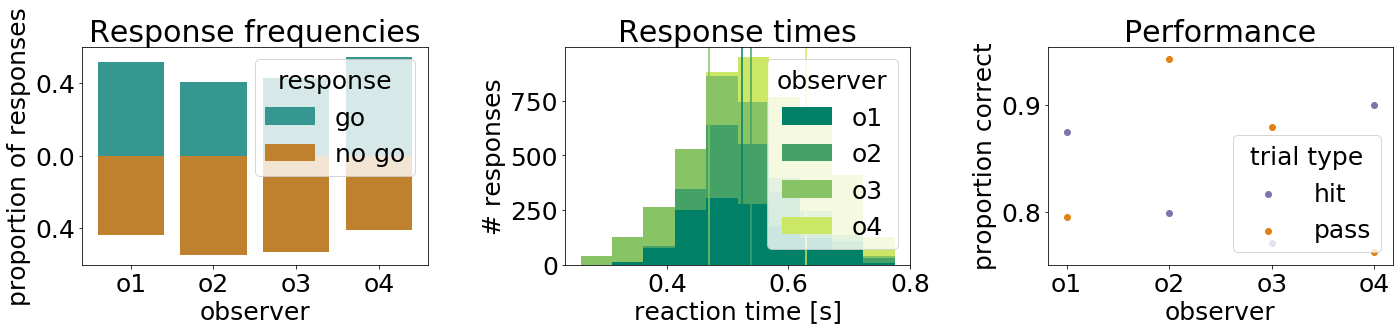

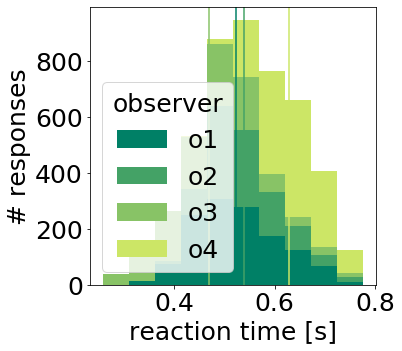

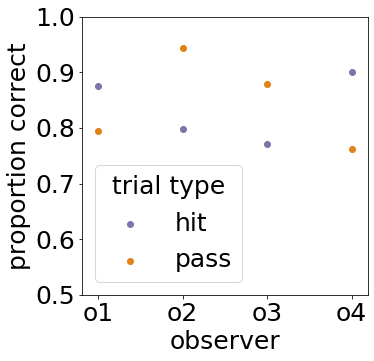

In [5]:
###############################################
# Build a figure for response characteristics #
###############################################
rts, p_hit, p_pass, obs = plotting.make_summary_plot(df_short, colormaps)

#********************#
# V-VSS 2021 figures #
#********************#
############################
# Figure 1: Reaction Times #
############################
VSS2021_rts, axs_rts = plt.subplots(1,1, figsize = (width*1.3, height*1.3))

# make a histogram of the reaction times, stacked by subject
axs_rts.hist(rts, stacked = True, color = colormaps['s_cm'], label = obs)

# draw a line at the mean
for s,c in zip(obs, colormaps['s_cm']):
    axs_rts.axvline(x = np.mean(df_short[df_short.subject == s].rea_time), color = c)

# set the labels
axs_rts.legend(title = 'observer', loc = 'lower left')
axs_rts.set_xlabel('reaction time [s]')
axs_rts.set_ylabel('# responses')

#########################
# Figure 2: performance #
#########################
VSS2021_performance, axs_perf = plt.subplots(1,1, figsize = (width*1.3, height*1.3))

# make a scatter plot of the performance in hit and pass trials
axs_perf.scatter(obs,p_hit, label = 'hit', color = colormaps['c_cm'](np.linspace(0.2,0.8,2))[1])
axs_perf.scatter(obs,p_pass, label = 'pass', color = colormaps['c_cm'](np.linspace(0.2,0.8,2))[0])

# set the labels and axis
axs_perf.set_xlabel('observer')
axs_perf.set_ylabel('proportion correct')
axs_perf.legend(title = 'trial type', loc = 'lower left')
axs_perf.set_ylim([0.5, 1])

###########################
# save the figures to pdf #
###########################
VSS2021_rts.savefig(path_figs + 'Fig1_ResponseTimes.pdf', bbox_inches = 'tight')
VSS2021_performance.savefig(path_figs + 'Fig2_Performance.pdf', bbox_inches = 'tight')

## 2. Response strategies
### Estimating the probability of a "hit"

Due to the random sampling from the goal's true location, samples can appear close to the attacker,
(suggesting a "hit" trial), even though the ground truth is a "pass" trial. Vice versa, samples can 
also appear far away from the attacker (suggesting a "pass" trial), even though the current trial is
a hit trial.

The distance between attacker and target can also be expressed in terms of a "hit probability", where
a distance between attacker and target that exceeds the goal's width results in a probability of 0, and
very small distances result in a probability close to one.


C:\Users\ClaraQ\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


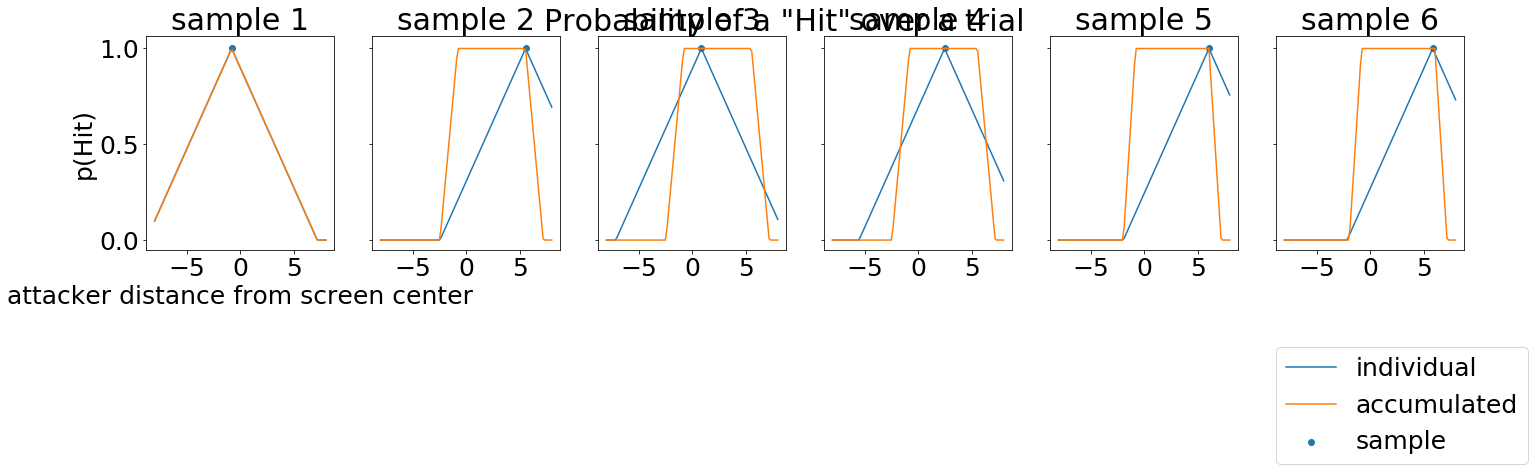

In [6]:
####################################
# Visualization of Hit Probability #
####################################
# create the plot
fig_probabilities, axs_probabilities = plt.subplots(1,6, figsize = (6 * width, height), sharex='all', sharey='all')

# select samples from one trial for visualization
samples = df_long[df_long.indTrial == 9].samplePosDegAtt.values
# set a range of possible attacker positions
attacker_range = np.linspace(-8,8, 100)
# set the goal width
goal_width = 8

# show the probabilities with each sample:
for s in range(0, len(samples)):
    # utils.get_pH is the function that converts distance into probabilities
    # sampleProb computes the cdf based on only one sample
    sampleProb = [utils.get_pH(samples[s],samples[s],a,goal_width) for a in attacker_range]
    # sampleAccProb computes the cdf based on all previously seen samples
    sampleAccProb = [utils.get_pH(min(samples[0: s+1]),max(samples[0: s+1]),a,goal_width) for a in attacker_range]
    
    # plot both probabilities
    axs_probabilities[s].plot(attacker_range, sampleProb, label = 'individual')
    axs_probabilities[s].plot(attacker_range, sampleAccProb, label = 'accumulated')
    axs_probabilities[s].scatter(samples[s], 1, label = 'sample')
    axs_probabilities[s].set_title(f"sample {s+1}")

# set some titles
fig_probabilities.suptitle('Probability of a "Hit" over a trial')
axs_probabilities[0].set_xlabel('attacker distance from screen center')
axs_probabilities[0].set_ylabel('p(Hit)')
axs_probabilities[5].legend(loc = (0,-1))


plt.tight_layout()

Shown above is the probability that the current trial is a "hit" or a "pass" trial (y axis), for different
attacker positions (x axis). 
6 samples are presented, their position is marked with a dot.

We compare two different probabilities. The "individual" probability is computed based only on the
most recently shown sample.
The "accumulated" probability is computed based on all currently presented samples.

We can see that for accumulated probabilities, samples shown between 2 known samples don't change the 
probability of a "hit". We also see, that the range of the goal covered by previous samples changes the steepness
of the drop in probability.

### Strategies to solve the task
We will compare different strategies to estimate the goal's true location:
    
1. the responses are evaluated on a sample-by-sample basis.
2. the responses are based on an average of individual samples.
3. the responses are based on a combined evaluation of all presented samples.
    
We will show, how performance evolves with each sample for the 3 strategies presented above.
Human observers perform this task under time pressure and will generate a response after ~500 ms, which corresponds to
3 presented samples.

The assumption made for this case is that observers will respond "go", when the probability of a hit
is larger than 0.5 and 'no-go' otherwise.

Text(0, 0.5, 'mean performance over all trials')

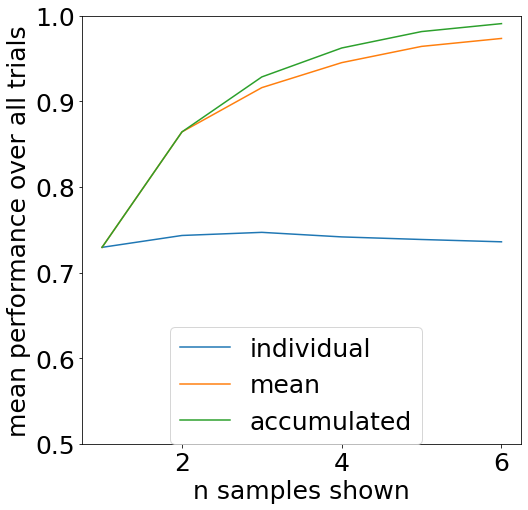

In [7]:
# run function to get predicted responses

# collect all trials in one array
trials = [df_long[df_long.indTrial == t] for t in np.unique(df_long.indTrial)]
samples = np.unique(df_long.sampleID)

# make a data frame to collect the performance
strategy_performance = pd.DataFrame(index = ['individual', 'mean', 'accumulated'], columns= samples)

# get the performance for 1-6 samples shown
for sample in samples:
    responses = utils.predict_responses(trials, 'all', sample)
    strategy_performance.loc['individual',sample] = utils.get_performance(responses[0], df_short.hitGoal.values)
    strategy_performance.loc['mean', sample] = utils.get_performance(responses[1], df_short.hitGoal.values)
    strategy_performance.loc['accumulated', sample] = utils.get_performance(responses[2], df_short.hitGoal.values)
    
# plot the performance for the 3 strategies
fig_strategies, axs_strategies = plt.subplots(1,1, figsize = (2 * width, 2 * height), sharex = 'all', sharey = 'all')

axs_strategies.plot(samples, strategy_performance.loc['individual',:], label = 'individual')
axs_strategies.plot(samples, strategy_performance.loc['mean',:], label = 'mean')
axs_strategies.plot(samples, strategy_performance.loc['accumulated',:], label = 'accumulated')

# add scale for y axis 
axs_strategies.set_ylim(0.5,1)
# add labels 
axs_strategies.legend(loc = (0.2,0))
axs_strategies.set_xlabel('n samples shown')
axs_strategies.set_ylabel('mean performance over all trials')


While the performance of the "individual" observer does not change with more samples. The performance of the
"mean" and the "accumulated" observers do increase over time in a highly comparable fashion, the accumulated observer 
achieves slightly better performance after the third sample.

The performance of the individual ideal observer is lower than performance of our human observers. Therefore, it is 
likely that human observers use a strategy where the information from different samples is combined. Differentiating 
between accumulating evidence and a linear combination of samples is difficult in this task, because both strategies
result in similar performance. The linear regression models I will compute in the next step are analogous to an observer
using the "mean" strategy, with different weights in each time window.
 
With the linear models, I want to demonstrate two things:
1. there is a significant interaction between the time when a sample was shown and the probability of a hit indicated 
by that sample that influences the response (go/ no-go) and the reaction time.
2. this interaction is non-linear. Therefore, it makes sense to estimate the slope of each sample individually.

Text(0, 0.5, 'proporton "go" responses')

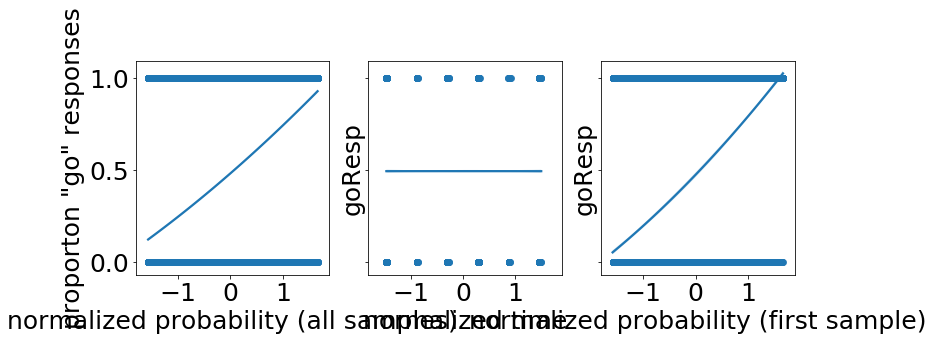

In [8]:
####################
# normalizing data #
####################
# Currently, probabilities range between 0 and 1, and time ranges between 0 and 840 ms. we want to 
# normalize both values to mean 0 and unit variance.

ldf_normal = utils.normalize_df(df_long.copy(), ['sampleTimeSecGo', 'sampleProbHit'])
sdf_normal = utils.normalize_df(df_short.copy(), ['sampleProbHit_01', 'sampleProbHit_02', 'sampleProbHit_03',
                                                  'sampleProbHit_04', 'sampleProbHit_05', 'sampleProbHit_06'])

# show the normalized values in a plot
fig_normalized_resp, axs_normalized_resp = plt.subplots(1,3, figsize = (3 * width, height), sharex = 'all', sharey = 'all')

sb.regplot(x = ldf_normal.sampleProbHit, y = ldf_normal.goResp, order = 2, ax = axs_normalized_resp[0])
sb.regplot(x = ldf_normal.sampleTimeSecGo, y = ldf_normal.goResp, order = 2, ax = axs_normalized_resp[1])
sb.regplot(x = sdf_normal.sampleProbHit_01, y = sdf_normal.goResp, order = 2, ax = axs_normalized_resp[2])

# some acis labels and titles
axs_normalized_resp[0].set_xlabel('normalized probability (all samples)')
axs_normalized_resp[1].set_xlabel('normalized time')
axs_normalized_resp[2].set_xlabel('normalized probability (first sample)')

axs_normalized_resp[0].set_ylabel('proportion "go" responses')

In [9]:
#####################################
# Fitting models with time variable #
#####################################
# fitting the full model
# we use R in the background here, because we are not aware of an established framework to fit mixed logisitc regressions
# in python.
responses_mfull = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 + sampleProbHit + sampleTimeSecGo | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_mfull.fit()

boundary (singular) fit: see ?isSingular 

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1+sampleProbHit+sampleTimeSecGo|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31457.696 	 AIC: 62935.392

Random effects:

                    Name    Var    Std
subject      (Intercept)  0.114  0.337
subject    sampleProbHit  0.005  0.073
subject  sampleTimeSecGo  0.001  0.029

                   IV1              IV2   Corr
subject    (Intercept)    sampleProbHit -0.791
subject    (Intercept)  sampleTimeSecGo -0.982
subject  sampleProbHit  sampleTimeSecGo  0.892

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.050,-0.381,0.282,0.169,0.952,0.683,1.325,0.488,0.406,0.570,-0.293,0.769,
sampleProbHit,1.237,1.162,1.312,0.038,3.444,3.195,3.713,0.775,0.762,0.788,32.250,0.000,***
sampleTimeSecGo,0.013,-0.021,0.048,0.018,1.013,0.979,1.049,0.503,0.495,0.512,0.756,0.449,
sampleProbHit:sampleTimeSecGo,-0.229,-0.251,-0.207,0.011,0.795,0.778,0.813,0.443,0.437,0.449,-20.056,0.000,***


In [10]:
# the full model produces singluar fits (indication for too many random effects).
# we will reduce the random effects in the next model
# The random slope for time has the smallest variance (explains little variance in the data)
# Therefore, we remove this random effect for the next model

responses_m1 = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 + sampleProbHit | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_m1.fit()

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.107 	 AIC: 62938.215

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.049,-0.379,0.280,0.168,0.952,0.684,1.324,0.488,0.406,0.570,-0.293,0.769,
sampleProbHit,1.235,1.161,1.310,0.038,3.440,3.193,3.706,0.775,0.761,0.788,32.482,0.000,***
sampleTimeSecGo,0.013,-0.007,0.032,0.010,1.013,0.993,1.032,0.503,0.498,0.508,1.286,0.198,
sampleProbHit:sampleTimeSecGo,-0.224,-0.246,-0.202,0.011,0.799,0.782,0.817,0.444,0.439,0.450,-19.850,0.000,***


In [11]:
# The model now converges. We will compare it to a model that has only a random intercept, and no random 
# slopes, because the variance explained by the random slopes for probability is also low.
responses_m2 = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_m2.fit()

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31478.503 	 AIC: 62967.006

Random effects:

                Name    Var    Std
subject  (Intercept)  0.109  0.331

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.042,-0.367,0.283,0.166,0.959,0.693,1.327,0.489,0.409,0.570,-0.253,0.800,
sampleProbHit,1.232,1.210,1.255,0.011,3.429,3.353,3.506,0.774,0.770,0.778,107.806,0.000,***
sampleTimeSecGo,0.012,-0.007,0.031,0.010,1.012,0.993,1.032,0.503,0.498,0.508,1.252,0.211,
sampleProbHit:sampleTimeSecGo,-0.224,-0.246,-0.202,0.011,0.799,0.782,0.817,0.444,0.439,0.450,-19.831,0.000,***


To compare the likelihoods of the two models, we can use a chi-square test
the second model (responses_m2) is our "null-model", because it assumes that the random slopes for probability
are zero. The first model (responses_m1) has a non-zero random slope. 

In [12]:
# the test statistic is the difference between the (-2 * REML log Likelihoods of the models)
TS = -2*responses_m2.logLike - -2*responses_m1.logLike 
# compute the p-value as a chi-squared distribution
pval = 0.5 * (1 - stats.chi2.cdf(TS, 1)) + 0.5 * (1 - stats.chi2.cdf(TS, 2))
# print the p-value
print(f"The p-value of the significance test is {pval}.")

The p-value of the significance test is 4.301762845937418e-08.


The p-value is below 0.05, so we should reject the null hypothesis and assume that there is a random slope for probability.
This means, that our model of choice is model responses_m1. In this model, we have seen that the only significant terms 
were the main effect of probability and the interaction between probability and time. 
We will fit a final model without the insignificant effects.

In [13]:
responses_linearmodel = Lmer('goResp ~ sampleProbHit + sampleProbHit:sampleTimeSecGo + (1 + sampleProbHit | subject)',
                    data = ldf_normal, family = 'binomial')
responses_linearmodel.fit()

Formula: goResp~sampleProbHit+sampleProbHit:sampleTimeSecGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.935 	 AIC: 62937.870

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.048,-0.376,0.279,0.167,0.953,0.687,1.322,0.488,0.407,0.569,-0.289,0.772,
sampleProbHit,1.235,1.161,1.309,0.038,3.439,3.193,3.704,0.775,0.762,0.787,32.629,0.000,***
sampleProbHit:sampleTimeSecGo,-0.223,-0.245,-0.201,0.011,0.800,0.782,0.818,0.444,0.439,0.450,-19.814,0.000,***


This analysis reveals, that there is a significant interaction between probability for a hit and time. The interaction is
negative. That means, the later a sample was presented the lower was it's impact of the response. However, this analysis
assumes that the interaction is linear.
We will do a simple visual test of this assumption: we will plot the relationship between response (go/ no-go) and 
probability individually for each sample and overlay the relationship estimated by our current model.

[1 2 3 4 5 6]


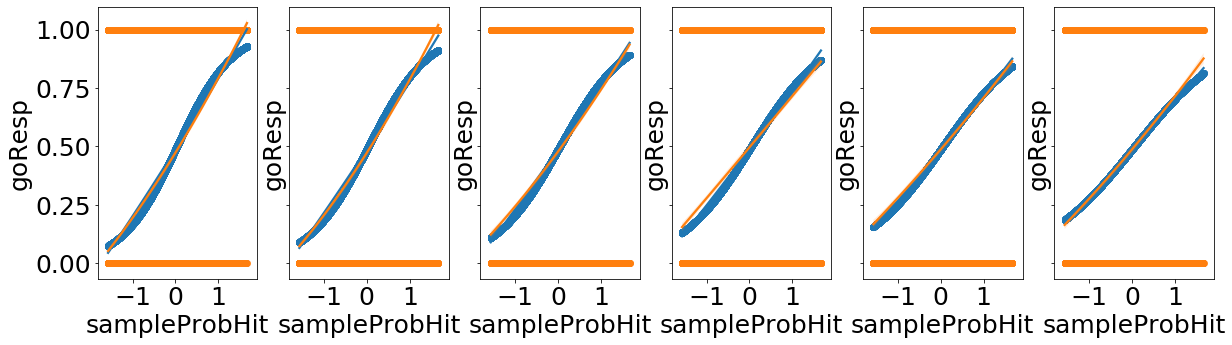

In [14]:
# run the function to plot predictions vs. individual time windows
plotting.plot_prediction_comparison(ldf_normal, responses_linearmodel)

The linear interaction seems to match the responses. But we have to wonder, why there is still a positive correlation 
between hit probability and response with sample six. We would not expect this relationship, because sample 6 was shown 
after a response was generated. So possibly, we see the positive relationship between hit probability and response only 
because the hit probability of sample 6 correlates with the hit probability of sample 1. 

We can use a quick correlation test to check for the correlation this.

In [17]:
# compute the covariance
cov_s1_s2 = np.cov(df_short.sampleProbHit_01, df_short.sampleProbHit_02)
print(f"the covariance between sample 1 and sample 6 is {cov_s1_s2}.")

# compute a t-test 
t_s1_s2, p_s1_s2 = stats.ttest_ind(df_short.sampleProbHit_01.values, df_short.sampleProbHit_02.values)
print(f"the t-statics for the covariance is {t_s1_s2} and the p_value is {p_s1_s2}.")

the covariance between sample 1 and sample 6 is [[0.09434889 0.03723159]
 [0.03723159 0.09530742]].
the t-statics for the covariance is 0.5441604608077754 and the p_value is 0.5863373846217399.


This analysis suggests that there is no difference between the distributions of sample 1 and sample 2
(and they were indeed sampled from the same distribution)

In [ ]:
#########################
# Miscellaneous figures #
#########################
# These figures were used to create visualizations of the experiment. 
# After they were build they were modified with Inkscape.

# colorbar for time 
cbar_fig, cbar_ax = plt.subplots(figsize=(3*width, 0.1))
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=colormaps['t_cm'], orientation='horizontal')

cbar_fig.savefig(path_figs + 'timescale.pdf', bbox_inches = 'tight')

# timeline with samples dots
VVSS2021_timecourse, axs_timecourse = plt.subplots(1,1, figsize = (3*width, height))

start = np.round(min(df_long.sampleTimeSecGo), 2) # earliest sample, rounded
end = np.round(max(df_long.sampleTimeSecGo), 2) # latest sample, rounded
n_sample = 6

axs_timecourse.scatter(np.linspace(start, end, n_sample),[1]*n_sample, color = 'black', s = 500)
axs_timecourse.set_xlim(0,1)
axs_timecourse.set_ylabel('samples')
axs_timecourse.set_xlabel('time since go signal [s]')

VVSS2021_timecourse.savefig(path_figs+'timecourse.pdf', bbox_inches = 'tight');